In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

data = pd.read_csv('Monthly_Rainfall_From_1901_to_2017.csv')
data.rename(columns={'Unnamed: 0': 'Name'}, inplace=True)

le = LabelEncoder()
data['States/UTs'] = le.fit_transform(data['States/UTs'])

X = data.drop(columns=['Name', 'ANNUAL'])
y = data['ANNUAL']

X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

lstm_model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1323.0840 - val_loss: 724.9754 - learning_rate: 0.0010
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 668.7859 - val_loss: 429.9207 - learning_rate: 0.0010
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 399.0302 - val_loss: 194.5439 - learning_rate: 0.0010
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 215.5836 - val_loss: 101.5956 - learning_rate: 0.0010
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 158.9137 - val_loss: 56.6616 - learning_rate: 0.0010
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 149.5538 - val_loss: 38.6743 - learning_rate: 0.0010
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 143.9980 - val_loss: 42.6461 - learning_rate: 0.0010
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 134.2060 - val_loss: 33.9585 - learning_rate: 0.0010
Epoch 9/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 136.5589 - val_loss: 52.3949 - lea

In [29]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

from sklearn.model_selection import RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)



RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [31]:

# Best parameters and RMSE
best_params = randomized_search.best_params_
best_model = randomized_search.best_estimator_

print("Best Parameters:", best_params)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
optimized_xgb_preds = best_model.predict(X_test)

# Calculate RMSE and MAE
optimized_rmse = np.sqrt(mean_squared_error(y_test, optimized_xgb_preds))
optimized_mae = mean_absolute_error(y_test, optimized_xgb_preds)

print(f"Optimized XGBoost Model - RMSE: {optimized_rmse:.4f}")
print(f"Optimized XGBoost Model - MAE: {optimized_mae:.4f}")


lstm_preds = lstm_model.predict(X_test_lstm).flatten()

alpha = 0.6
hybrid_preds = alpha *optimized_xgb_preds + (1 - alpha) * lstm_preds

def evaluate_model(y_true, y_pred, model_name):
    """Evaluates a model using RMSE, MAE, and R2 score."""

    min_length = min(len(y_true), len(y_pred))
    y_true = y_true.iloc[:min_length]
    y_pred = y_pred[:min_length]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Model: {model_name}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR2: {r2:.4f}\n")

evaluate_model(y_test,optimized_xgb_preds, "XGBoost")
evaluate_model(y_test, lstm_preds, "LSTM")
evaluate_model(y_test, hybrid_preds, "Hybrid Model")

# Use the best_model (trained by RandomizedSearchCV) to get feature importances
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance (XGBoost):")
print(xgb_importance)



import joblib
best_model.save_model("xgb_model.json")

lstm_model.save("lstm_model.keras")

Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Optimized XGBoost Model - RMSE: 75.0904
Optimized XGBoost Model - MAE: 46.4551
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model: XGBoost
RMSE: 75.0904
MAE: 46.4551
R2: 0.9938

Model: LSTM
RMSE: 28.3977
MAE: 16.0192
R2: 0.9991

Model: Hybrid Model
RMSE: 48.1269
MAE: 28.5131
R2: 0.9975

Feature Importance (XGBoost):
       Feature  Importance
7          JUN    0.565712
8          JUL    0.094577
9          AUG    0.069936
6          MAY    0.054919
0   States/UTs    0.054761
10         SEP    0.054722
11         OCT    0.034293
5          APR    0.022403
3          FEB    0.017530
4          MAR    0.012294
12         NOV    0.007978
2          JAN    0.006035
13         DEC    0.004092
1         YEAR    0.000749


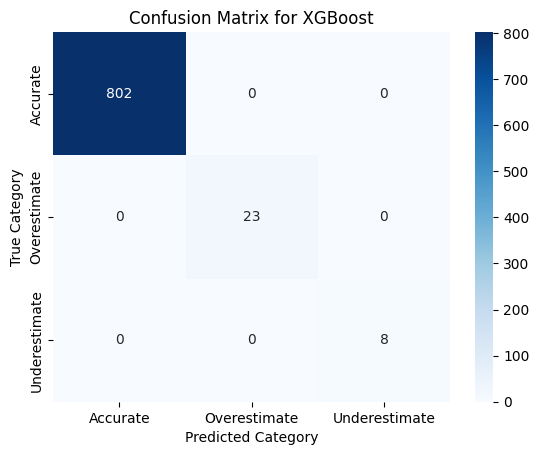

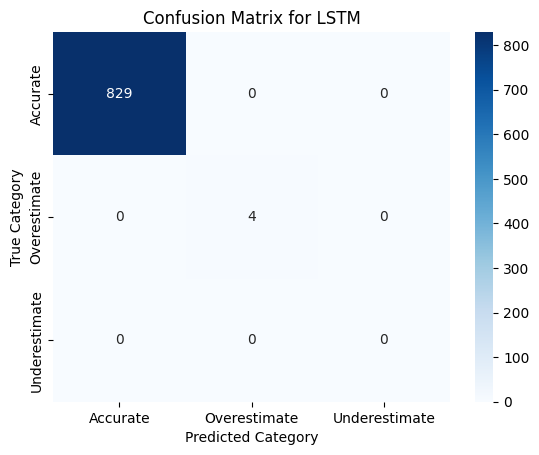

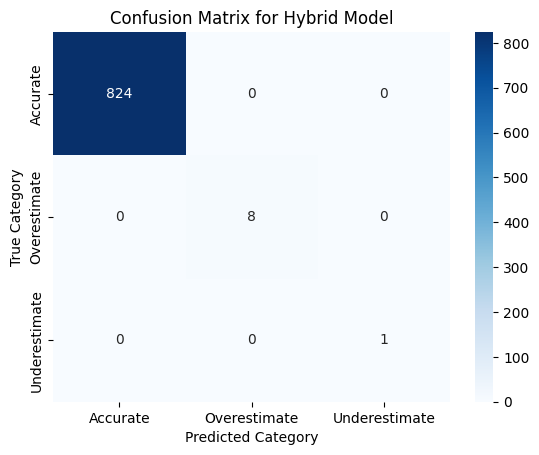

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def categorize_predictions(y_true, y_pred, tolerance=0.1):
    """Categorize predictions into Accurate, Overestimate, and Underestimate."""
    errors = y_pred - y_true
    within_tolerance = np.abs(errors) <= (tolerance * y_true)
    overestimate = errors > (tolerance * y_true)
    underestimate = errors < -(tolerance * y_true)

    categories = np.zeros_like(errors, dtype=int)
    categories[within_tolerance] = 0
    categories[overestimate] = 1
    categories[underestimate] = 2
    return categories


def plot_confusion_matrix(y_true, y_pred, model_name, tolerance=0.1):
    """Plot confusion matrix for regression predictions."""
    y_true_categorized = categorize_predictions(y_true, y_pred, tolerance)
    y_pred_categorized = categorize_predictions(y_true, y_pred, tolerance)
    cm = confusion_matrix(y_true_categorized, y_pred_categorized, labels=[0, 1, 2])

    labels = ['Accurate', 'Overestimate', 'Underestimate']
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Category")
    plt.ylabel("True Category")
    plt.show()


tolerance = 0.1

plot_confusion_matrix(y_test,optimized_xgb_preds, "XGBoost", tolerance)
plot_confusion_matrix(y_test, lstm_preds, "LSTM", tolerance)
plot_confusion_matrix(y_test, hybrid_preds, "Hybrid Model", tolerance)


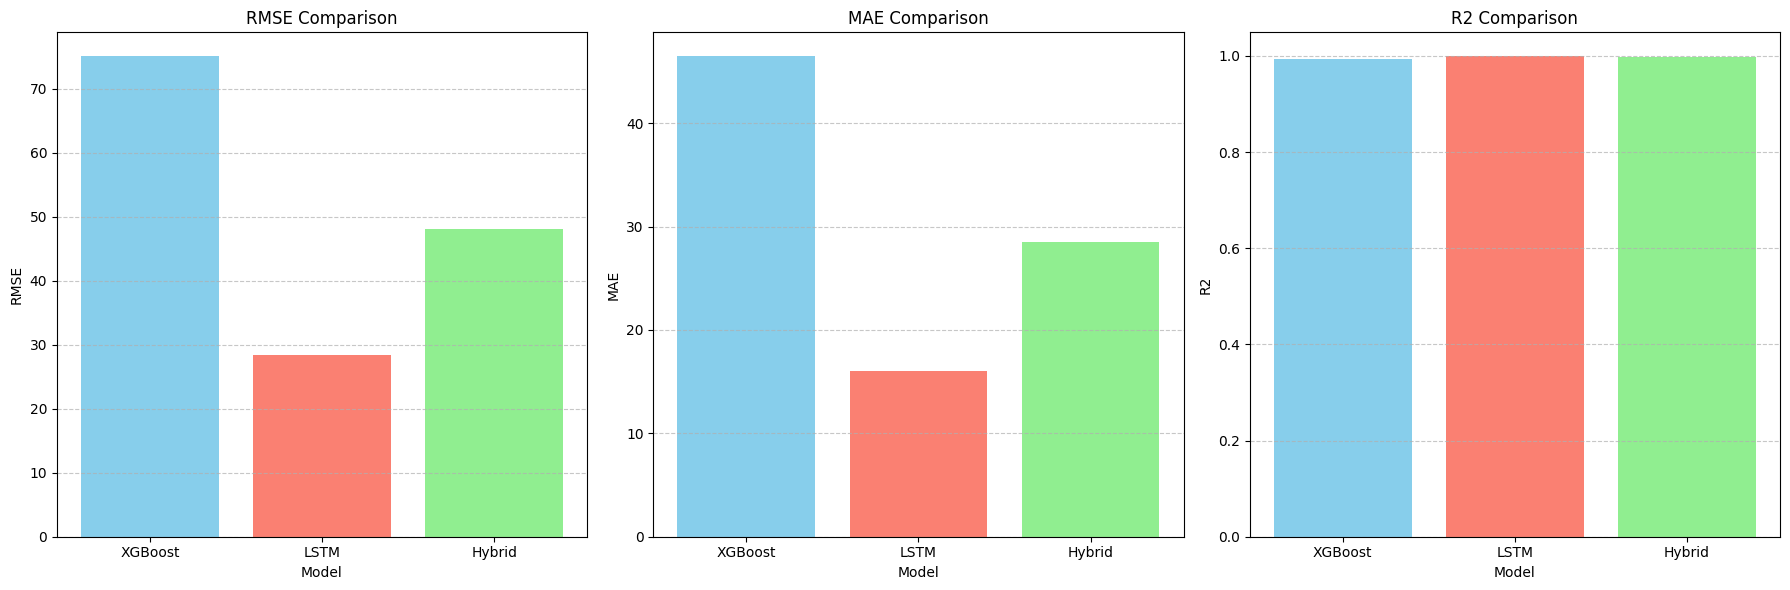

In [33]:
def get_metrics(y_true, y_pred):
    """Calculate RMSE, MAE, and R2 score."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

xgb_metrics = get_metrics(y_test,optimized_xgb_preds)
lstm_metrics = get_metrics(y_test, lstm_preds)
hybrid_metrics = get_metrics(y_test, hybrid_preds)

metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM', 'Hybrid'],
    'RMSE': [xgb_metrics[0], lstm_metrics[0], hybrid_metrics[0]],
    'MAE': [xgb_metrics[1], lstm_metrics[1], hybrid_metrics[1]],
    'R2': [xgb_metrics[2], lstm_metrics[2], hybrid_metrics[2]],
})

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Bar plots for each metric
for i, metric in enumerate(['RMSE', 'MAE', 'R2']):
    ax[i].bar(metrics_df['Model'], metrics_df[metric], color=['skyblue', 'salmon', 'lightgreen'])
    ax[i].set_title(f'{metric} Comparison')
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Model')
    ax[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


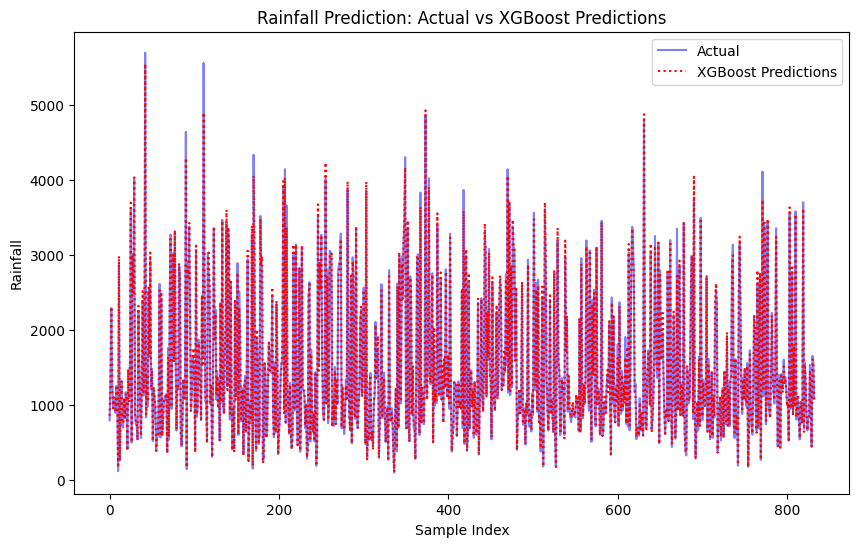

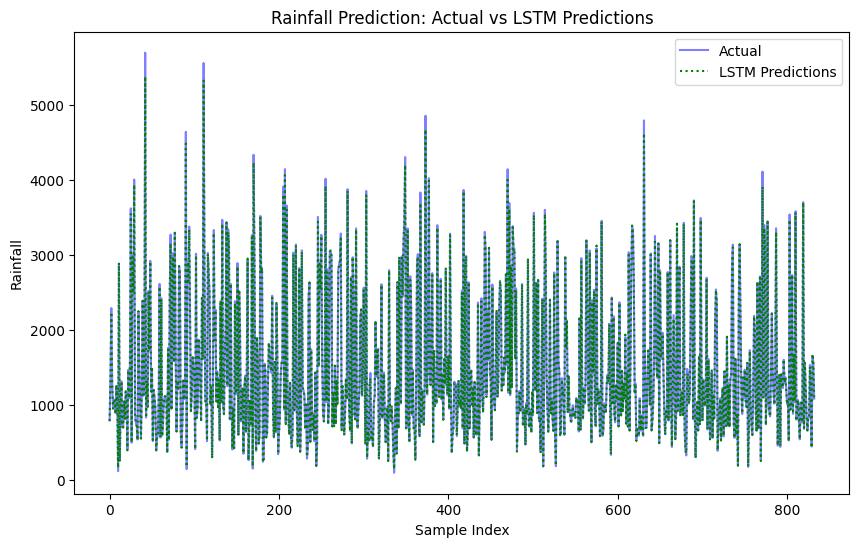

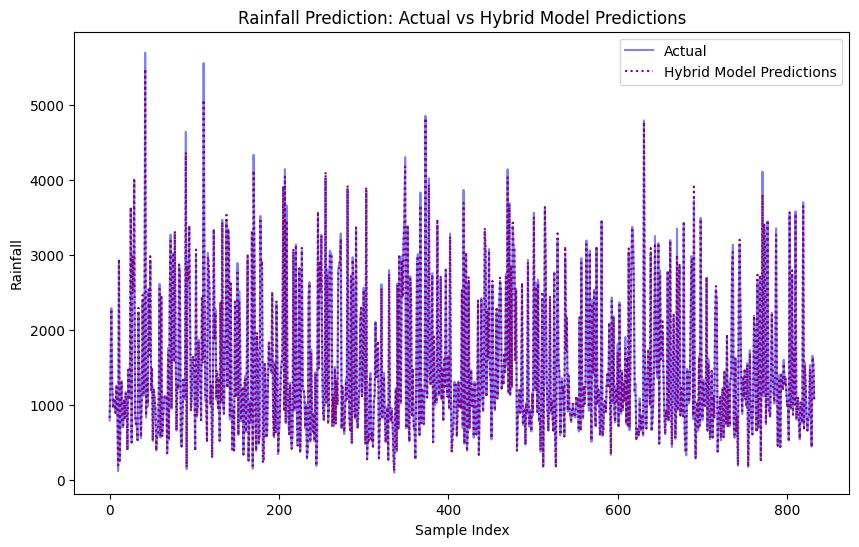

In [34]:
min_length = min(len(y_test), len(hybrid_preds))
y_test_aligned = y_test.iloc[:min_length]

plt.figure(figsize=(10, 6))
plt.plot(y_test_aligned.values, label='Actual', color='blue',alpha=0.5)
plt.plot(optimized_xgb_preds[:min_length], label='XGBoost Predictions', color='red', linestyle='dotted')
plt.legend()
plt.title("Rainfall Prediction: Actual vs XGBoost Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_aligned.values, label='Actual', color='blue',alpha=0.5)
plt.plot(lstm_preds[:min_length], label='LSTM Predictions', color='green', linestyle='dotted')
plt.legend()
plt.title("Rainfall Prediction: Actual vs LSTM Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_aligned.values, label='Actual', color='blue',alpha=0.5)
plt.plot(hybrid_preds[:min_length], label='Hybrid Model Predictions', color='purple', linestyle='dotted')
plt.legend()
plt.title("Rainfall Prediction: Actual vs Hybrid Model Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall")
plt.show()